In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
    
file = filedir + 'potential_params_1000_with_initeqbestfit.txt'

dopotfit = False

In [3]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np
from scipy import optimize as opt

from astropy import units

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *

import datetime
import random

%matplotlib inline

With eat_snap_and_fof we can read in simulations from snapnr 3.

Number of DM particles (does not change during simulation run): 34,898,087

Let's take a random sample which makes $0.5\%$:

$0.005 \cdot 34898087 \approx 175000$



Potential fitting function input values
---

- maximum R [Mpc] - def 2 * s.galrad
- mask to fit potential (default - dm)
    - 0: all
    - 1: gas
    - 2: DM
    - 3: stars
    
- number of particles
- fitting function (default - emcee1)
    - if emcee1 number of walkers, number of steps
- savefile
- R0 [kpc] - def 8kpc

parameters:
- plot
- save
- verbose


In [4]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc / _REFR0_kpc
    b_MND  = b_MND_kpc / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB)
    return [disk, halo, bulge]


In [5]:
#_____function for MCMC, sum of error squares_____
def lnprob_MCMC(x, *args):
    
    # read fitting parameters:
    v0_kms     = x[0]
    a_MND_kpc  = x[1]
    b_MND_kpc  = x[2]
    a_NFWH_kpc = x[3]
    a_HB_kpc   = x[4]
    n_MND      = x[5]
    n_NFWH     = x[6]
    n_HB       = 1. - n_NFWH - n_MND
    
    # check if imput parameters are physical:
    if v0_kms <= 0: return -np.inf
    # (Note: all other parameters are checked during setting up the galpy potential.)
        
    #read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    pot_kms2_data = args[2]
    _REFR0_kpc    = args[3]
    
    # setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc)
    except Exception as e:
        #uncomment for debugging:
        #print e.message
        #print x
        return -np.inf

    #calculate potential values at (R,z) for this potential:
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data / _REFR0_kpc,
                                   z_kpc_data / _REFR0_kpc) * (v0_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(-0.5 * (pot_kms2_data - pot_kms2_model)**2)
    return err

In [6]:
def potential_fit(maxr_Mpc, _REFR0_kpc = 8., mask_num = 2, part_num = 1501, \
                  v0_kms_init = 150., a_MND_kpc_init = 6., b_MND_kpc_init = 1., \
                  a_NFWH_kpc_init = 10., a_HB_kpc_init = 2., n_MND_init = 0.2, n_NFWH_init = 0.6, \
                  fitroutine = 'emcee1', nwalkers = 50, nstep = 1000, \
                  file = file, res_arr = [], plot = False, save = False, verbose = False):
    
    ### selection masks
    # select ALL particles belonging to the main galaxy within maxr
    if mask_num == 0:
        mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) )
        parts_to_fit = 'all'
    # select GAS particles belonging to the main galaxy within maxr
    if mask_num == 1:
        mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 0) )
        parts_to_fit = 'gas'
    # select DM particles belonging to the main galaxy within maxr
    if mask_num == 2:
        mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
        parts_to_fit = 'DM'
    # select STAR particles belonging to the main galaxy within maxr
    if mask_num == 3:
        mask, = np.where( (s.halo == 0) & (s.r() < maxr_Mpc) & (s.r() > 0.) & (s.type == 4) )
        parts_to_fit = 'star'
    
    if verbose == True:
        print('The potential is fitted to ' + str(part_num) + ' random selected ' + parts_to_fit + ' particles.')
   
    # select data with mask
    r_kpc = 1000. * s.r()[mask]
    (R_kpc, phi_rad, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, mask) 
    pot_kms2 = s.pot[mask]
    
    # draw random sample out of data
    try:
        rand_samp = np.array(random.sample(list(enumerate(pot_kms2)), part_num))
        rand_ind = rand_samp[:,0].astype(int)
        pot_kms2_data = rand_samp[:, 1]
        r_kpc_data = r_kpc[rand_ind]
        R_kpc_data = R_kpc[rand_ind]
        z_kpc_data = z_kpc[rand_ind]
    except ValueError:        
        pot_kms2_data = pot_kms2
        r_kpc_data = r_kpc
        R_kpc_data = R_kpc
        z_kpc_data = z_kpc
    
    if fitroutine == 'emcee1': # maybe implement diff ev but not now
        # _____prepare MCMC_____
        ndim, nwalkers, nstep = 7, nwalkers, nstep

        # initial values for fit:
        # init values as input of function
        initial_guess = np.array([v0_kms_init, a_MND_kpc_init, b_MND_kpc_init, a_NFWH_kpc_init, \
                                  a_HB_kpc_init, n_MND_init, n_NFWH_init])
        initial_guess_width = np.fabs(0.2 * initial_guess)
        p0 = np.array([np.random.randn(ndim) * np.array(initial_guess_width) + initial_guess \
                                                      for i in range(nwalkers)])
        # fiitting boundaries:
        boundaries = np.array([[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,np.inf],[0.,1.],[0.,1.]])
        for pp in range(ndim):
            p0[(p0[:,pp] < boundaries[pp,0]),pp] = initial_guess[pp] + np.random.uniform() * 0.1
            p0[(p0[:,pp] > boundaries[pp,1]),pp] = initial_guess[pp] - np.random.uniform() * 0.1

        # _____run MCMC_____
        sampler = emcee.EnsembleSampler(nwalkers, ndim,
                                       lnprob_MCMC,
                                       args = [R_kpc_data, z_kpc_data, pot_kms2_data, _REFR0_kpc])
        sampler.run_mcmc(p0, nstep)

        # result:
        burnin = int(nwalkers / 2.) # check what this is used for. #1000
        final_samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        chain_samples = sampler.chain

        median = np.median(final_samples,axis=0)
        std = np.std(final_samples,axis=0)

        v0_kms_bestfit     = median[0]
        a_MND_kpc_bestfit  = median[1]
        b_MND_kpc_bestfit  = median[2]
        a_NFWH_kpc_bestfit = median[3]
        a_HB_kpc_bestfit   = median[4]
        n_MND_bestfit      = median[5]
        n_NFWH_bestfit     = median[6]
        n_HB_bestfit       = 1. - (n_MND_bestfit + n_NFWH_bestfit)

        v0_kms_bestfit_err     = std[0]
        a_MND_kpc_bestfit_err  = std[1]
        b_MND_kpc_bestfit_err  = std[2]
        a_NFWH_kpc_bestfit_err = std[3]
        a_HB_kpc_bestfit_err   = std[4]
        n_MND_bestfit_err      = std[5]
        n_NFWH_bestfit_err     = std[6]
        n_HB_bestfit_err       = (n_MND_bestfit_err + n_NFWH_bestfit_err)

        
        
    # save potential parameters with errors and snapnr:
        pot_bestfit = np.array([v0_kms_bestfit, v0_kms_bestfit_err, a_MND_kpc_bestfit, a_MND_kpc_bestfit_err, \
                            b_MND_kpc_bestfit, b_MND_kpc_bestfit_err, a_NFWH_kpc_bestfit, a_NFWH_kpc_bestfit_err, \
                            a_HB_kpc_bestfit, a_HB_kpc_bestfit_err, n_MND_bestfit, n_MND_bestfit_err, \
                            n_NFWH_bestfit, n_NFWH_bestfit_err, n_HB_bestfit, n_HB_bestfit_err])
        
    res_arr = np.append(res_arr, pot_bestfit)
    #np.savetxt(file, pot_bestfit, fmt = '%10.15f')
    
    # generate potential measurements:
    pot_galpy_bestfit = setup_galpy_potential(a_MND_kpc_bestfit,b_MND_kpc_bestfit,
                                           a_NFWH_kpc_bestfit,a_HB_kpc_bestfit,
                                           n_MND_bestfit,n_NFWH_bestfit,n_HB_bestfit, _REFR0_kpc)
    pot_kms2_bestfit = evaluatePotentials(pot_galpy_bestfit,
                                       R_kpc_data/_REFR0_kpc,
                                       z_kpc_data/_REFR0_kpc) * (v0_kms_bestfit)**2
    if fitroutine == 'emcee1':
        sampler.reset()

    return res_arr

In [7]:
if dopotfit == True:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
    level = 4

    j = 0
    startsnap = 60
    endsnap = 128
    for halo_number in [24]:  # range(1, 31):
        halodir = basedir+"halo_{0}/".format(halo_number)
        snappath = halodir+"output/"
        for snapnr in range(startsnap,endsnap,1):
            #print("level   : {0}".format(level))
            #print("halo    : {0}".format(halo_number))
            print("snapnr  : {0}".format(snapnr))
            print(datetime.datetime.now().time())
            #print("basedir : {0}".format(basedir))
            #print("halodir : {0}".format(halodir))
            #print("snappath: {0}\n".format(snappath))
            try:
                s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3], 
                haloid=0, galradfac=0.1, verbose=False, rotate_disk=False, do_rotation=False, use_principal_axis=False) 
            except KeyError:
                print('\n\n', snapnr, 'not read in.\n\n')
                continue

            # Clean negative and zero values of gmet to avoid RuntimeErrors
            # later on (e.g. dividing by zero)
            #s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
            #print('Maximum phase space extend of snapshot' + str(snapnr) + 'in Mpc:', np.max(s.r()))
            if j == 0:
                res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 10000)
                res_arr = np.insert(res_arr, 0, snapnr)
                j +=1
                v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]


            else:
                res_arr = potential_fit(maxr_Mpc = 2. * s.galrad, part_num = 175000, nstep = 1000, res_arr=res_arr, \
                                        v0_kms_init = v0_kms__bestfit, a_MND_kpc_init = a_MND_kpc_bestfit, \
                                        b_MND_kpc_init = b_MND_kpc_bestfit, a_NFWH_kpc_init = a_NFWH_kpc_bestfit, \
                                        a_HB_kpc_init = a_HB_kpc_bestfit, n_MND_init = n_MND_bestfit, \
                                        n_NFWH_init = n_NFWH_bestfit)
                res_arr = np.insert(res_arr, 17 * (snapnr - startsnap ), snapnr)

                v0_kms_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 1]
                a_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 3]
                b_MND_kpc_bestfit   = res_arr[int(17 * (snapnr - startsnap )) + 5]
                a_NFWH_kpc_bestfit  = res_arr[int(17 * (snapnr - startsnap )) + 7]
                a_HB_kpc_bestfit    = res_arr[int(17 * (snapnr - startsnap )) + 9]
                n_MND_bestfit       = res_arr[int(17 * (snapnr - startsnap )) + 11]
                n_NFWH_bestfit      = res_arr[int(17 * (snapnr - startsnap )) + 13]
                n_HB_bestfit        = res_arr[int(17 * (snapnr - startsnap )) + 15]

            #print(res_arr)

            if (snapnr % 10) ==0:

                f = open(file, 'w') # existing file will be overwritten
                f.write("#snapnr\tv0_kms_bestfit\tv0_kms_bestfit_err\ta_MND_kpc_bestfit\ta_MND_kpc_bestfit_err\tb_MND_kpc_bestfit\tb_MND_kpc_bestfit_err\ta_NFWH_kpc_bestfit\ta_NFWH_kpc_bestfit_err\ta_HB_kpc_bestfit\ta_HB_kpc_bestfit_err\tn_MND_bestfit\tn_MND_bestfit_err\tn_NFWH_bestfit\tn_NFWH_bestfit_err\tn_HB_bestfit\tn_HB_bestfit_err\n")
                f.close()
                f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
                np.savetxt(f,res_arr)
                f.close()


    res_arr = res_arr.reshape(endsnap-startsnap,17) # instead of 4 number of simulations fitted

    np.savetxt(filedir + 'safetyfile_1000_initbestfit.txt', res_arr)

    f = open(file, 'w') # existing file will be overwritten
    f.write("#snapnr\tv0_kms_bestfit\tv0_kms_bestfit_err\ta_MND_kpc_bestfit\ta_MND_kpc_bestfit_err\tb_MND_kpc_bestfit\tb_MND_kpc_bestfit_err\ta_NFWH_kpc_bestfit\ta_NFWH_kpc_bestfit_err\ta_HB_kpc_bestfit\ta_HB_kpc_bestfit_err\tn_MND_bestfit\tn_MND_bestfit_err\tn_NFWH_bestfit\tn_NFWH_bestfit_err\tn_HB_bestfit\tn_HB_bestfit_err\n")
    f.close()
    f = open(file,'ab') # open file in append and binary mode to make savetxt work and append
    np.savetxt(f,res_arr)
    f.close()


[[ 1883.29653075   150.00311903   111.49665166   101.39353309
     94.81872357   366.84975879   208.34192656    88.74094002]
 [ 1799.9325137    145.49176837   105.78284581    85.73421637
     91.08855824   350.68162101   205.7334165     88.62673709]
 [  285.43779257   129.42947221   105.08817076    85.37607616
     87.10145964   349.23254369   162.6696862     73.83695095]
 [  266.2241855    128.93575157   103.86812552    83.41941234
     78.69768304   345.01390618   162.36878106    73.79480433]
 [  122.49938826   126.57283299    98.75792491    81.38313153
     77.68068046   344.62448958   140.3687926     69.18867981]
 [  122.48104116   126.56903799    98.66334597    81.06276566
     75.75817484   339.72856845   137.93339645    69.18173119]
 [   94.77111183   123.9561865     96.7431209     80.45694392
     74.75934587   339.70536728   119.44023418    67.34297542]
 [   85.02175598   122.47383972    95.11324054    80.45691302
     71.26894495   336.70897893   119.40656667    64.75484808]


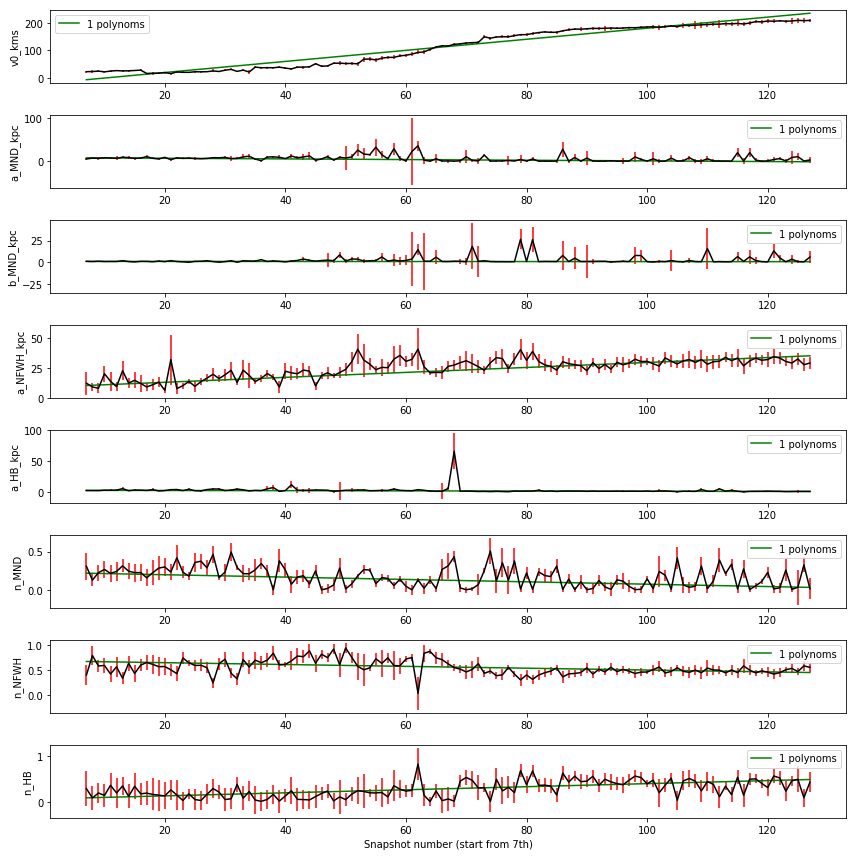

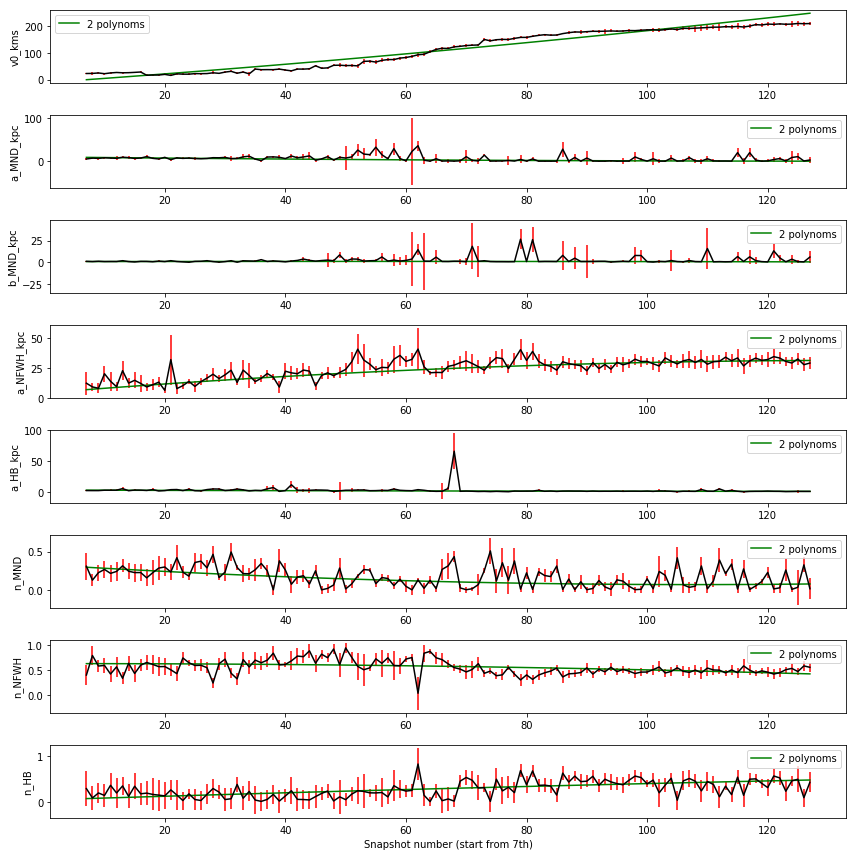

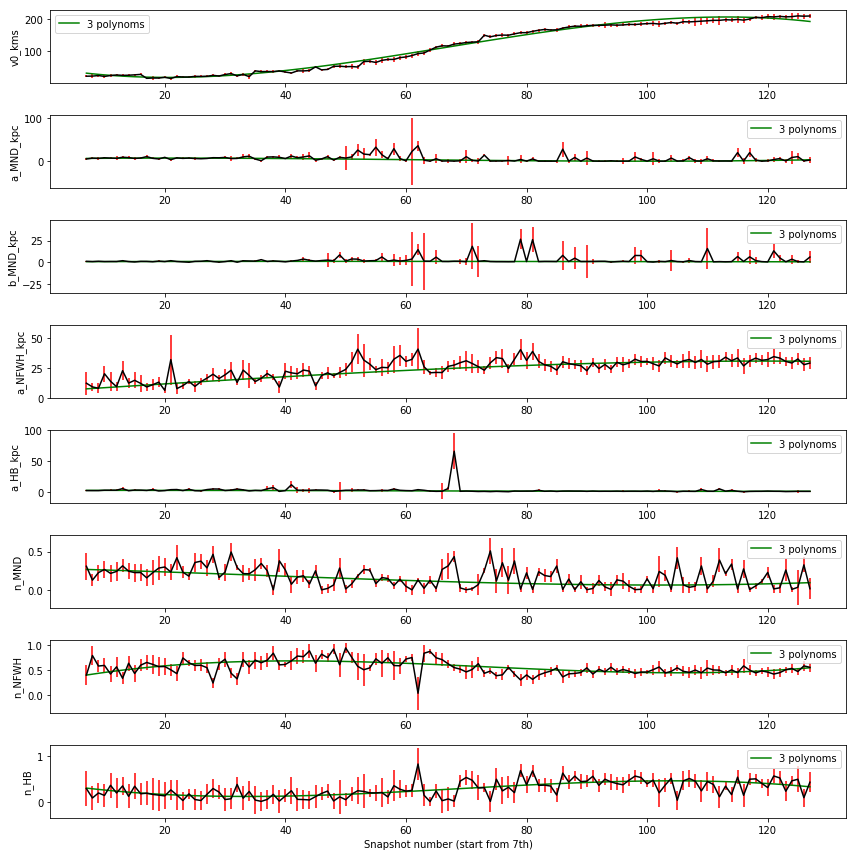

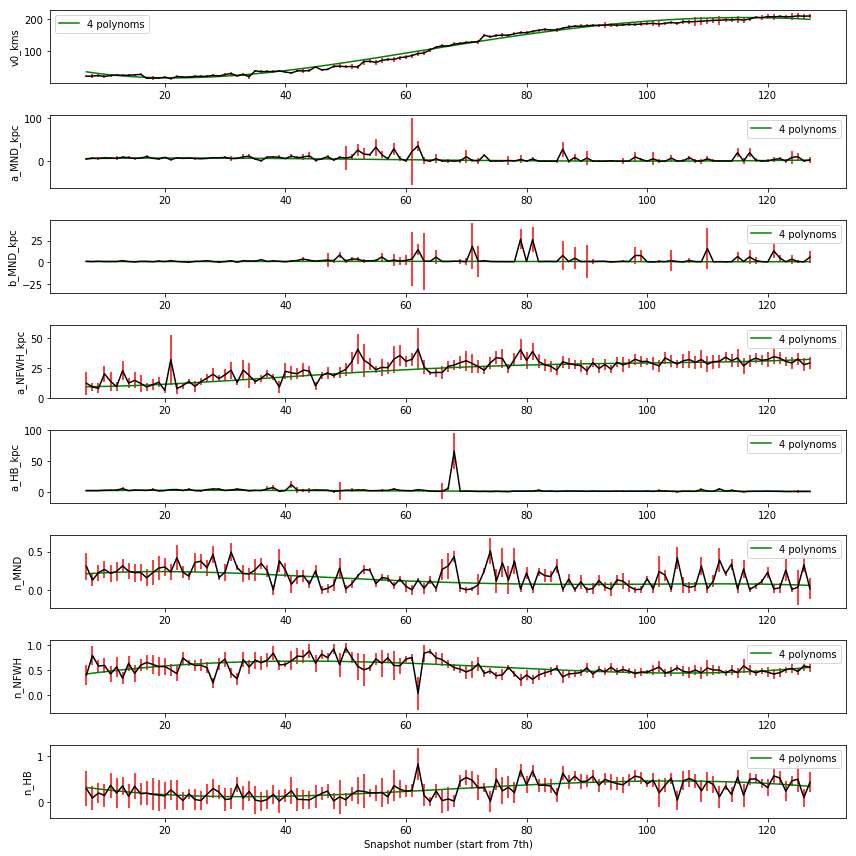

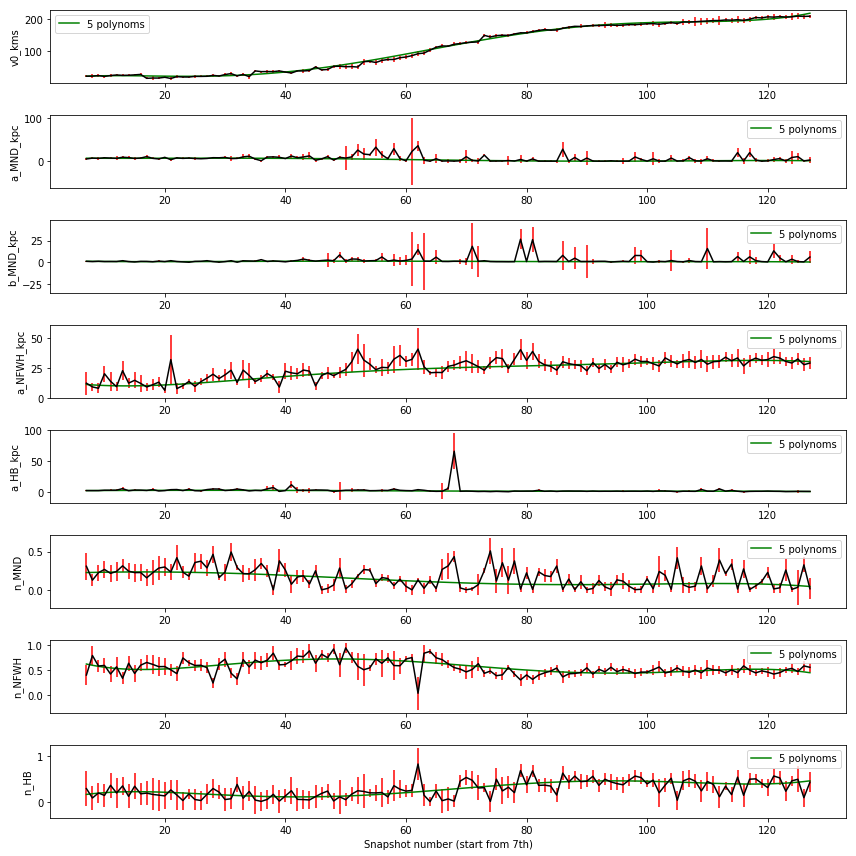

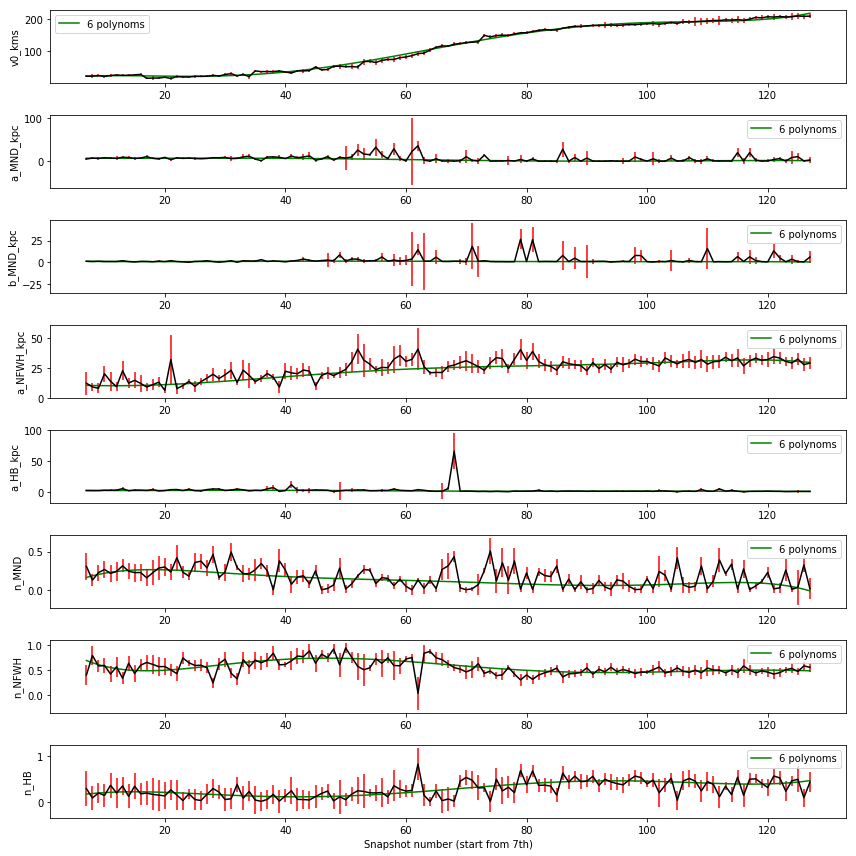

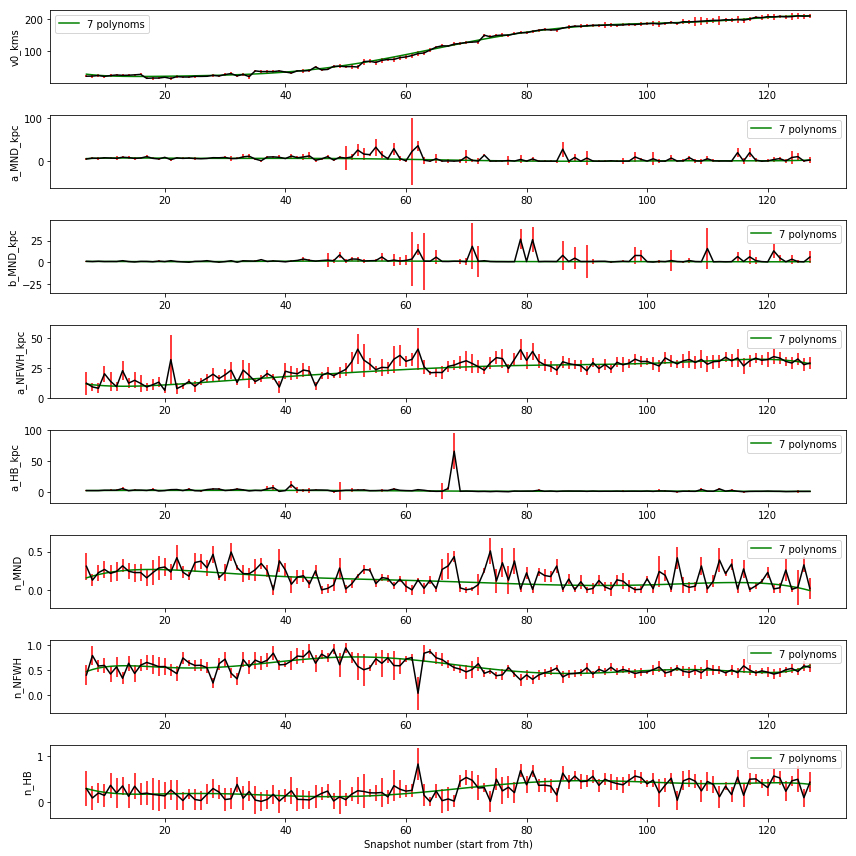

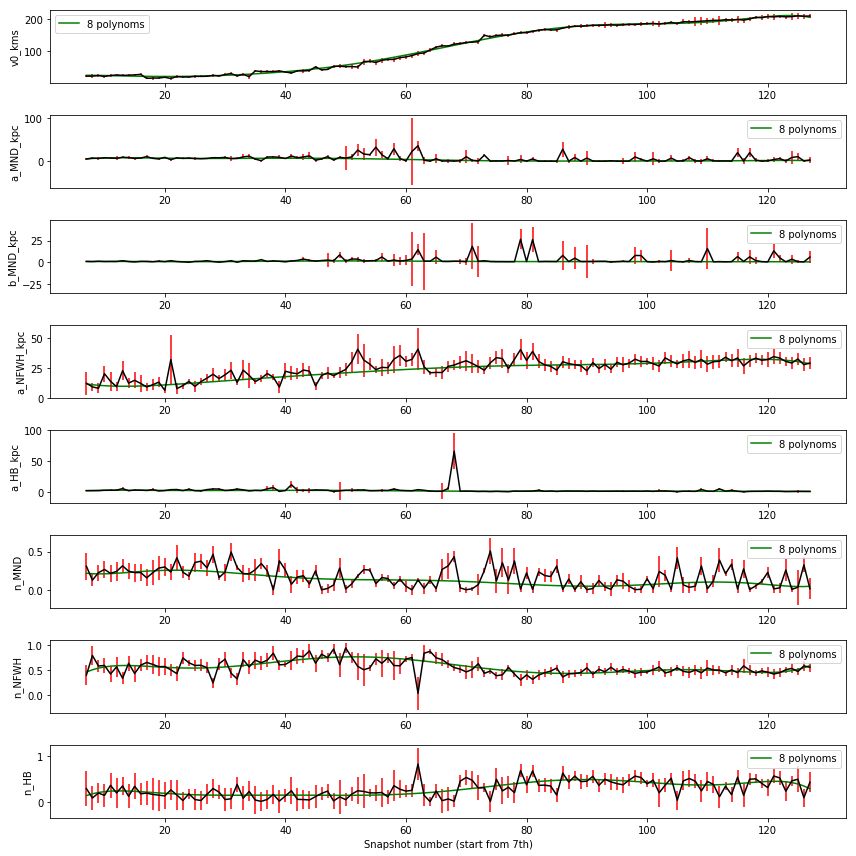

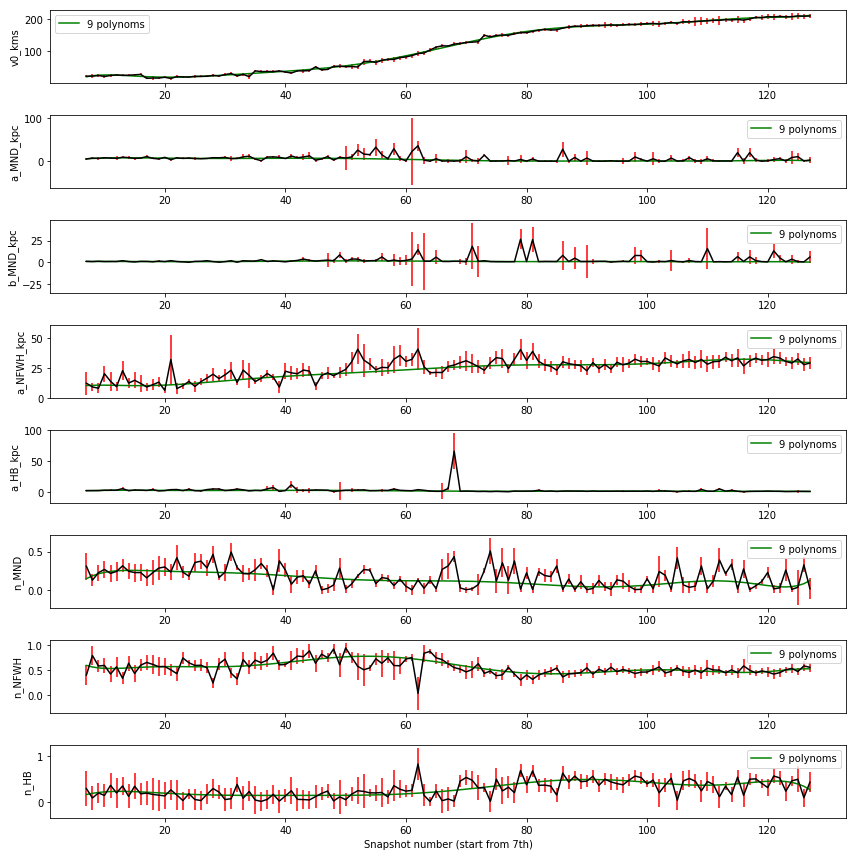

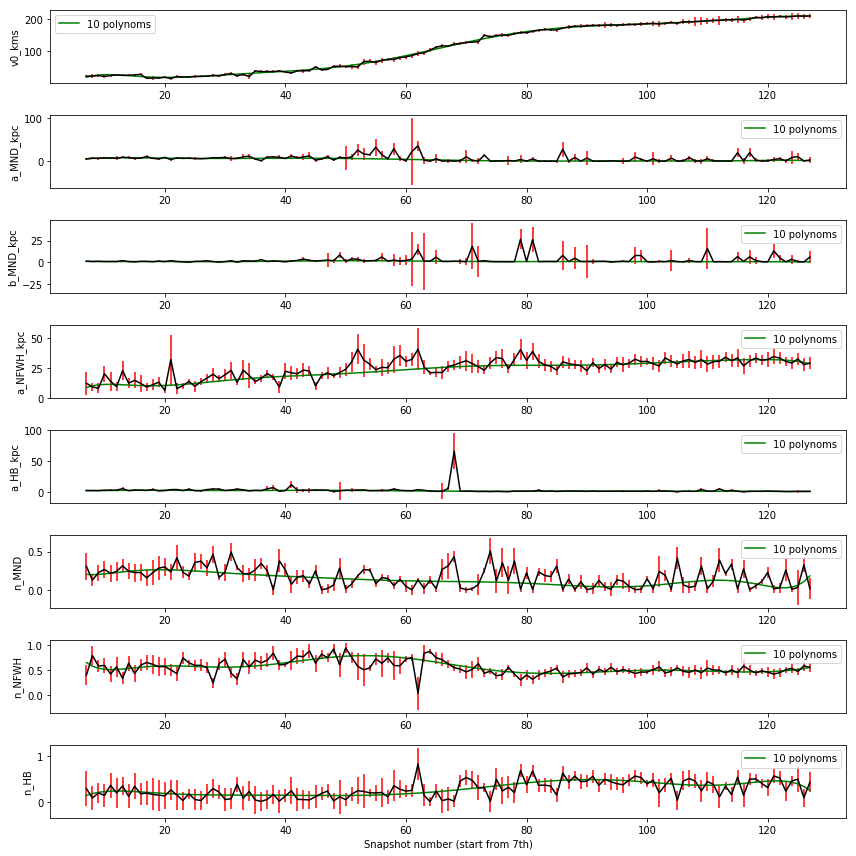

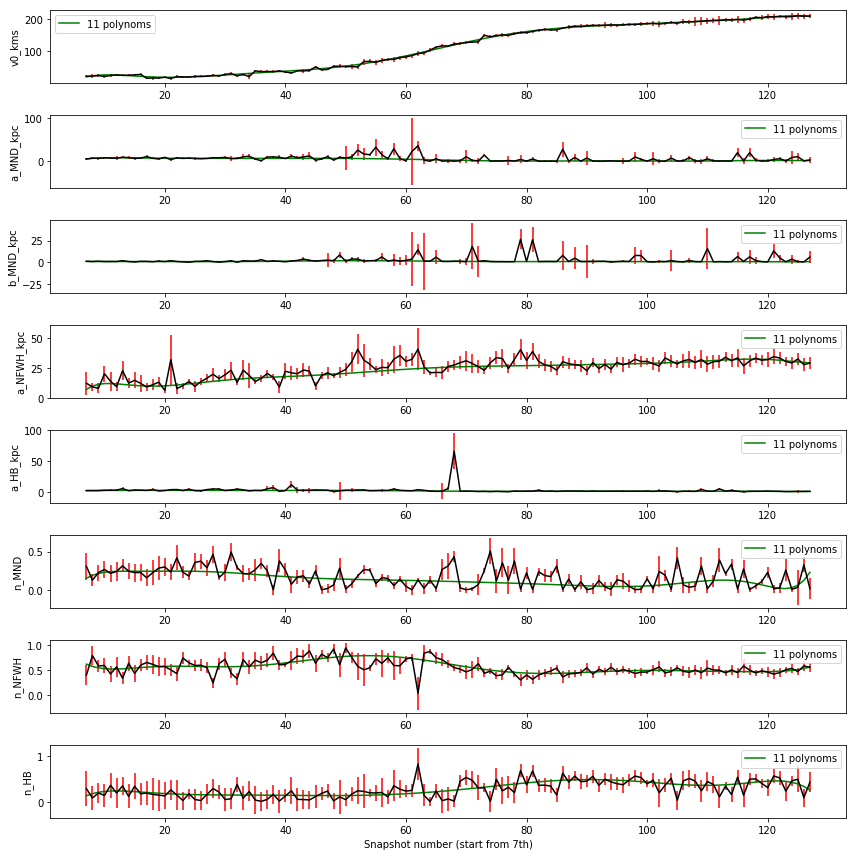

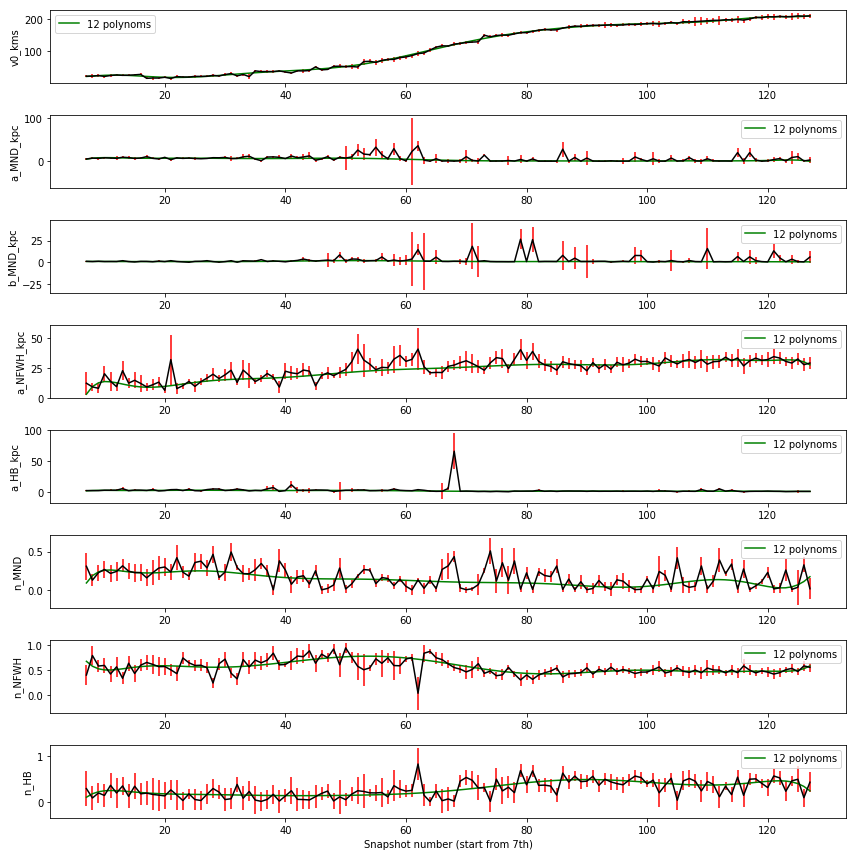

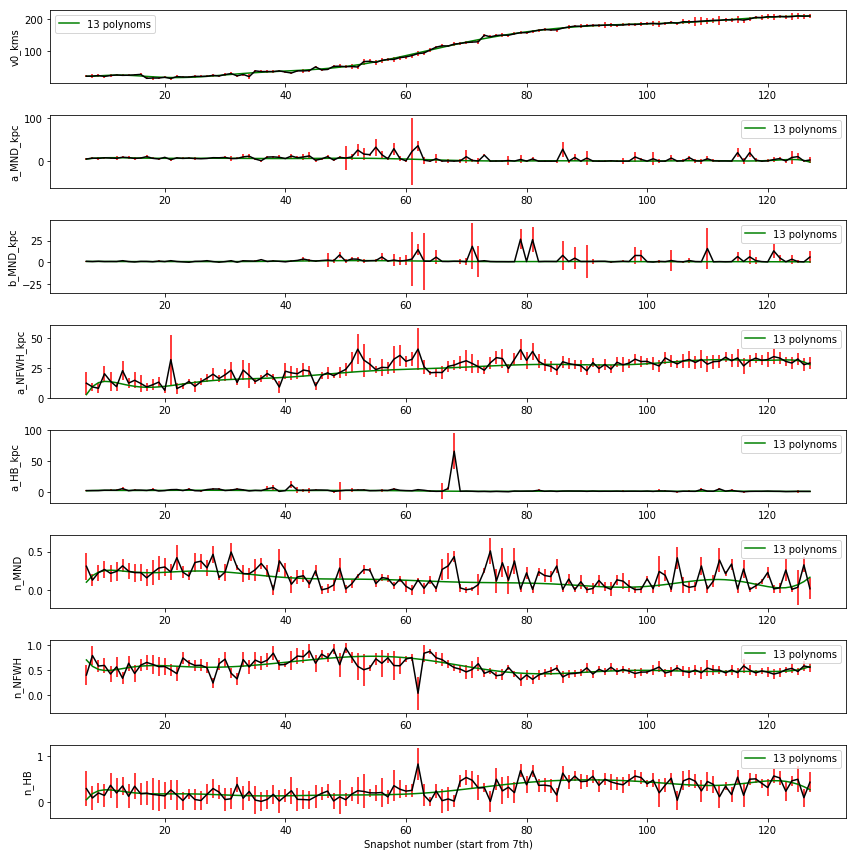

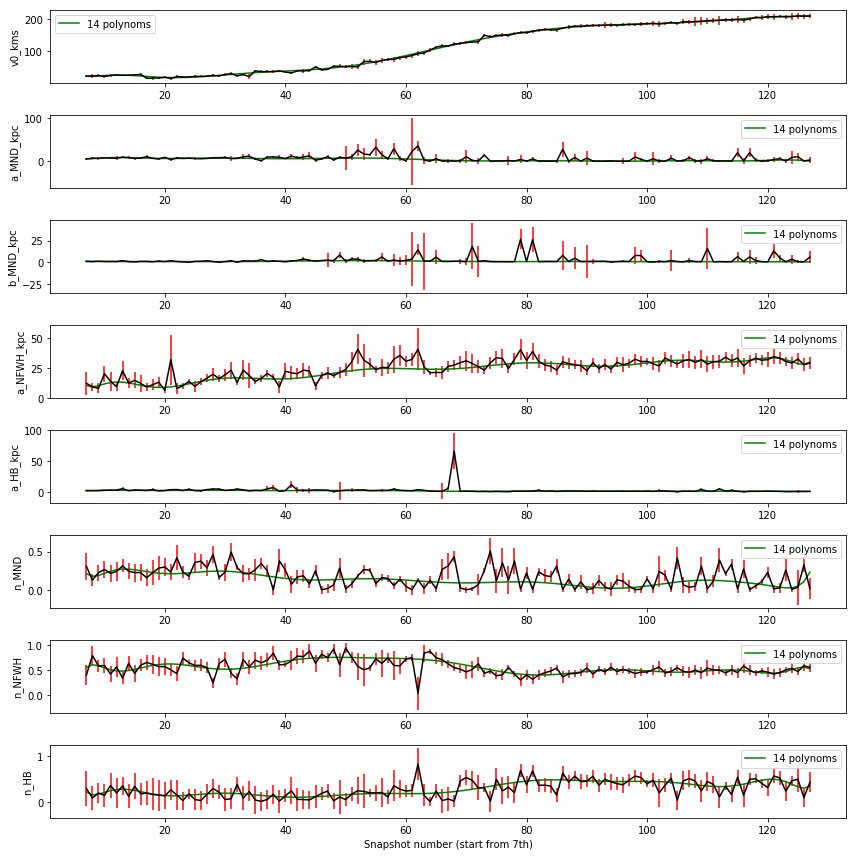

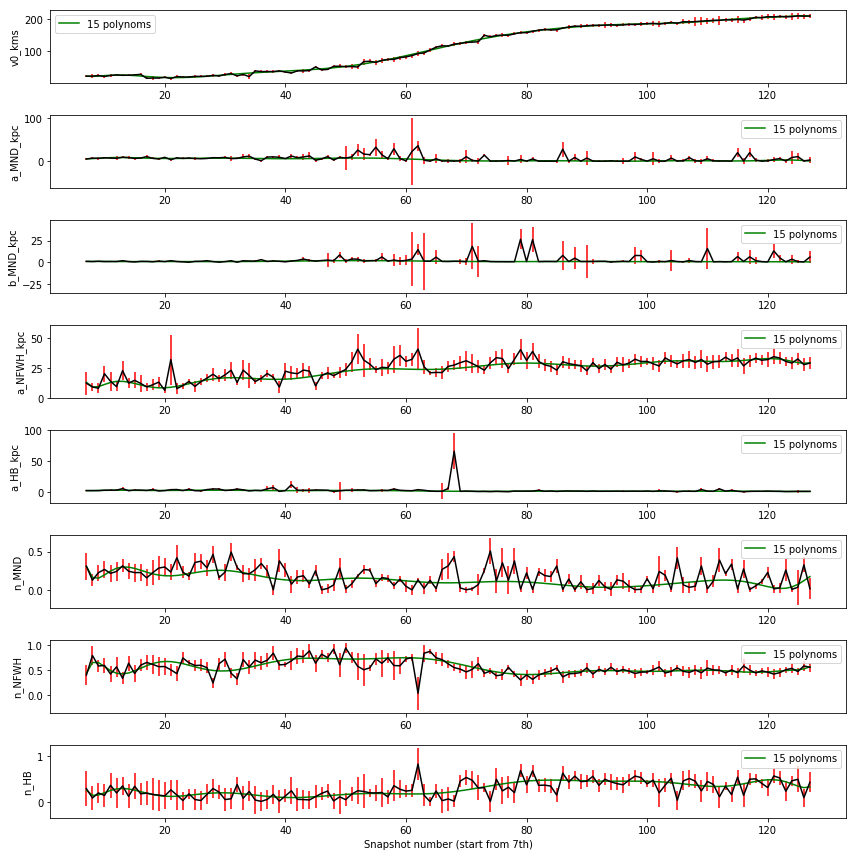

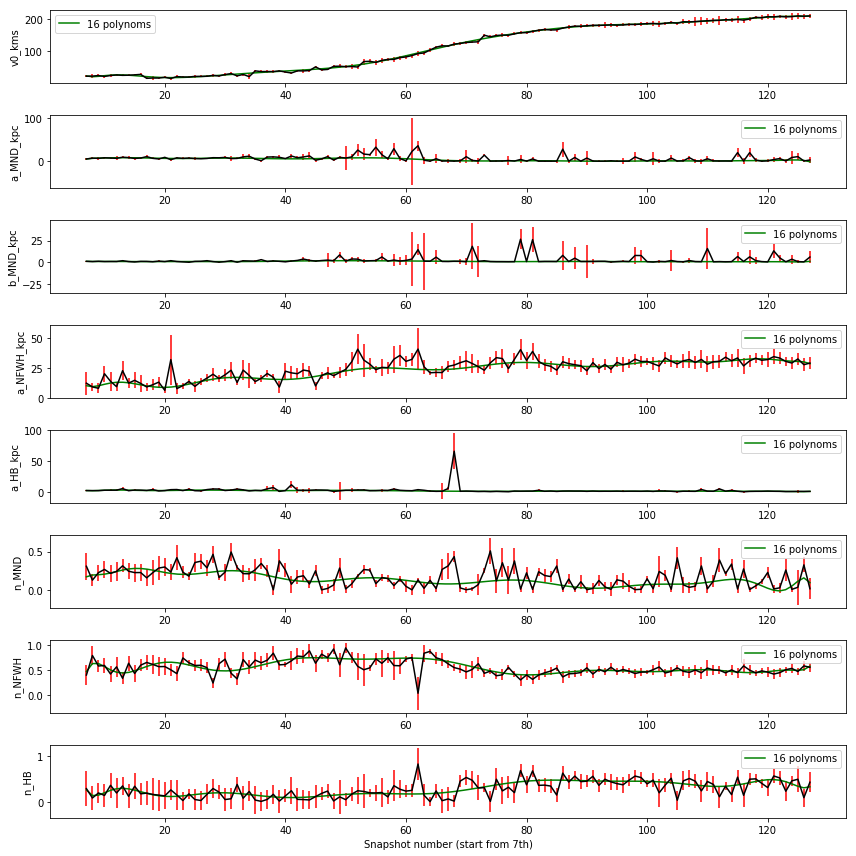

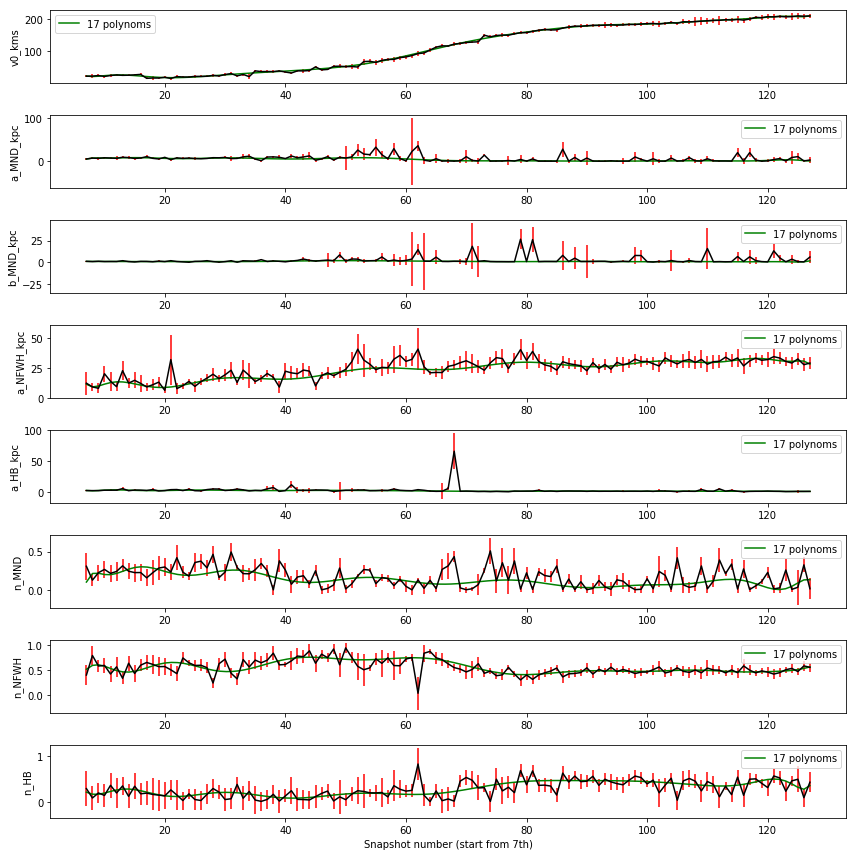

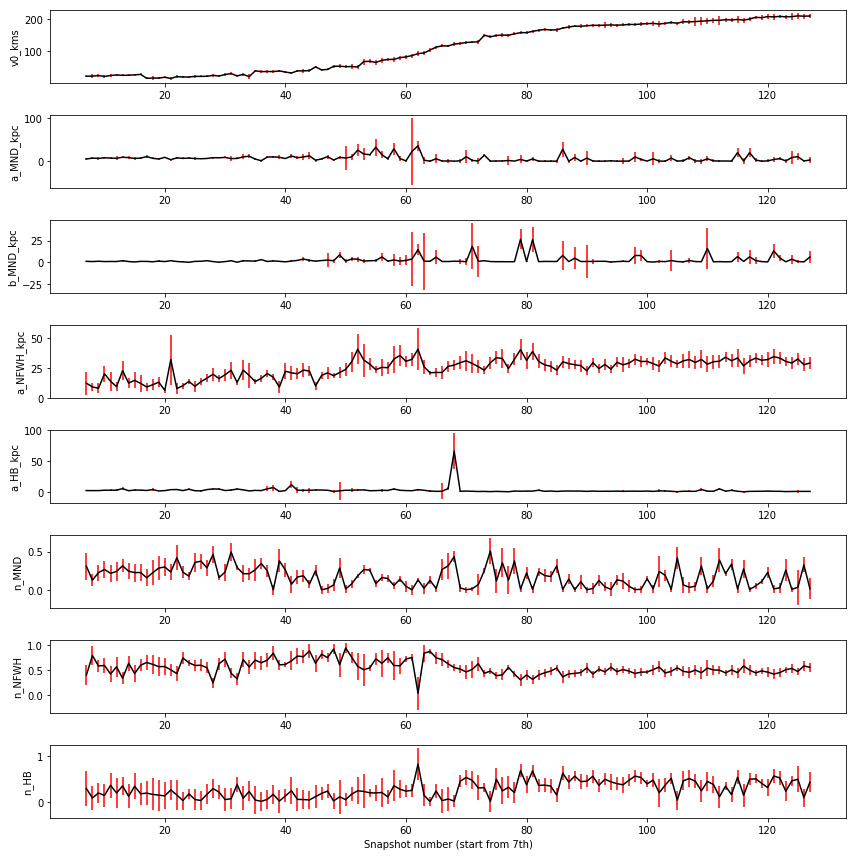

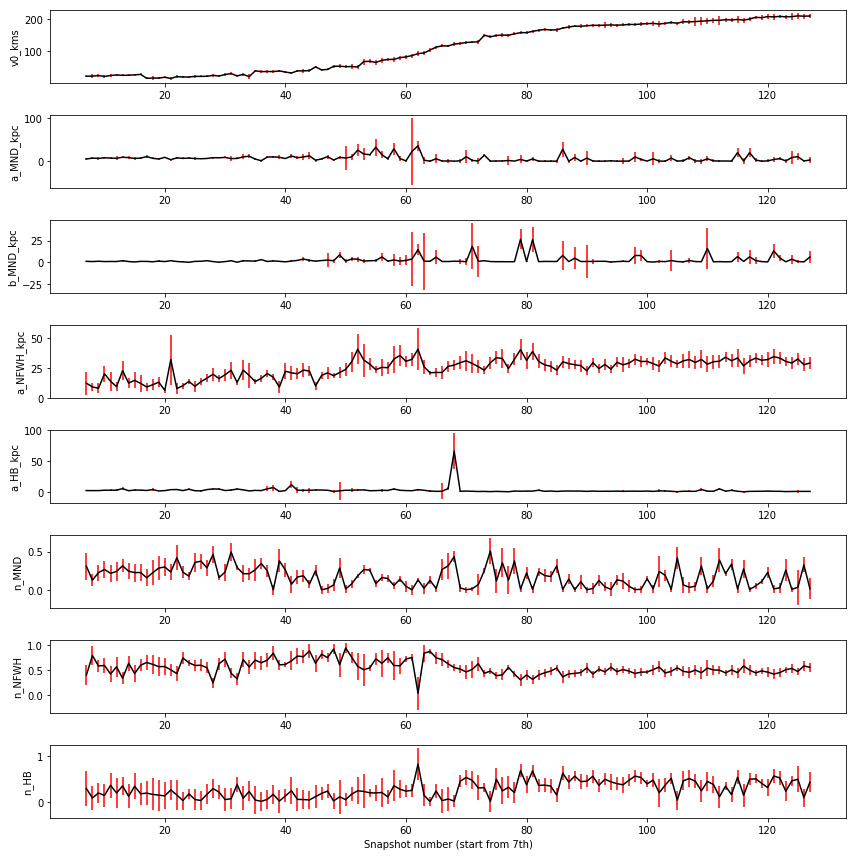

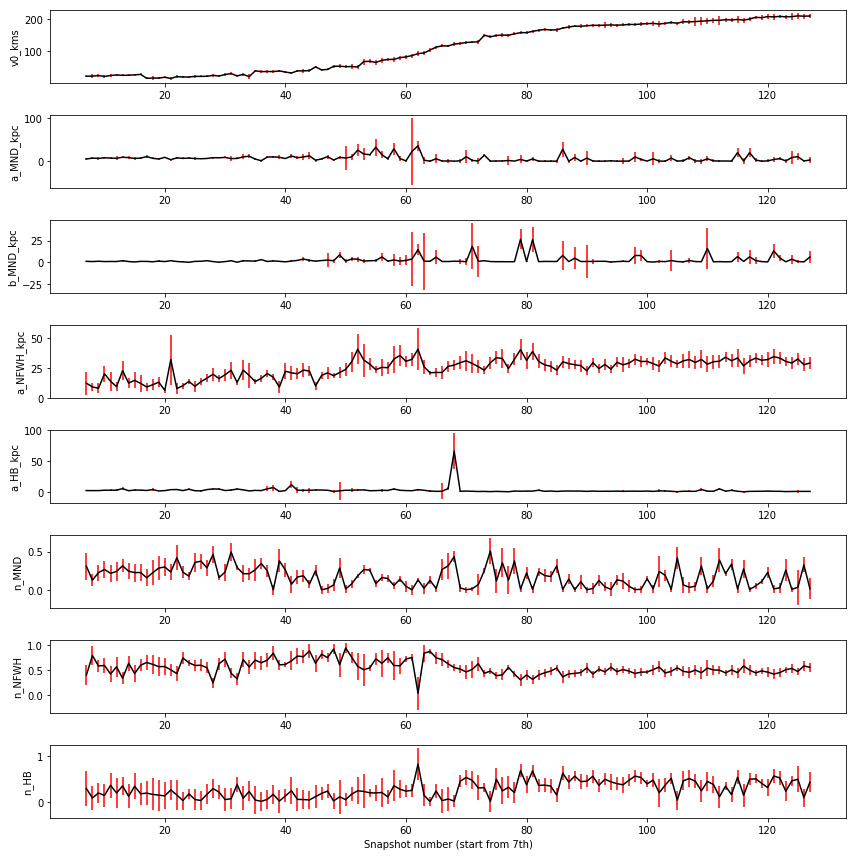

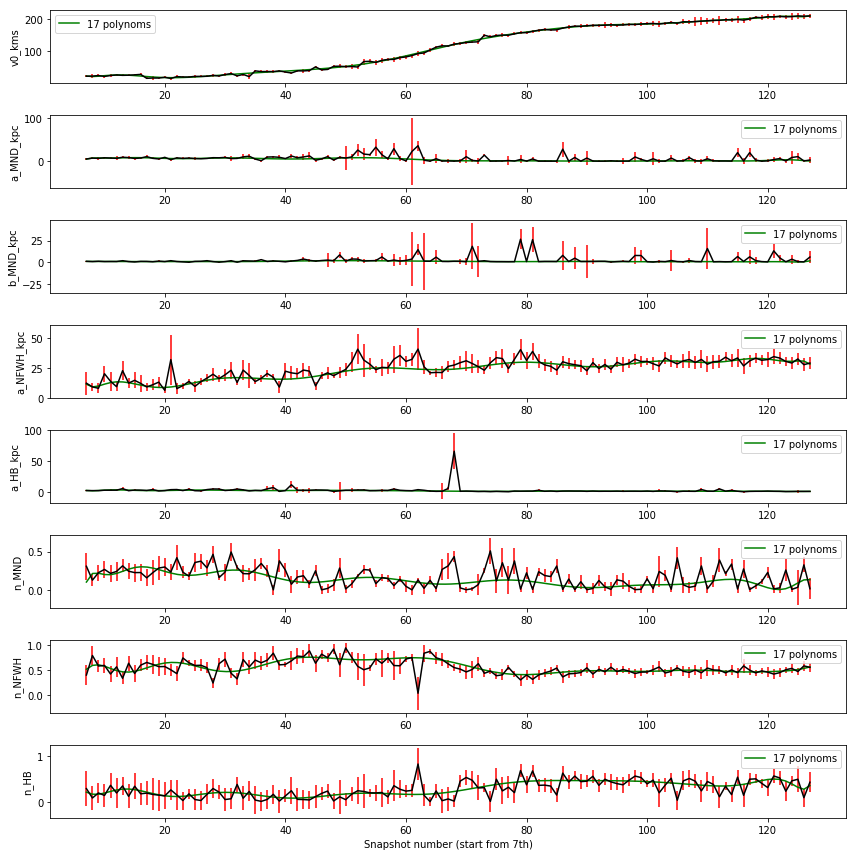

In [78]:
# pot_params = np.loadtxt(filedir + 'potential_params_1000.txt')
# wenn dann das file richtig ist funktioniert folgendes (hoffentlich):

snapnr          = pot_params[:,0]
v0_kms          = pot_params[:,1]
v0_kms_err      = pot_params[:,2]
a_MND_kpc       = pot_params[:,3]
a_MND_kpc_err   = pot_params[:,4]
b_MND_kpc       = pot_params[:,5]
b_MND_kpc_err   = pot_params[:,6]
a_NFWH_kpc      = pot_params[:,7]
a_NFWH_kpc_err  = pot_params[:,8]
a_HB_kpc        = pot_params[:,9]
a_HB_kpc_err    = pot_params[:,10]
n_MND           = pot_params[:,11]
n_MND_err       = pot_params[:,12]
n_NFWH          = pot_params[:,13]
n_NFWH_err      = pot_params[:,14]
n_HB            = pot_params[:,15]
n_HB_err        = pot_params[:,16]

snapnr = np.array(snapnr, dtype = int)


'''
ndim = 7
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]

f, axes = plt.subplots(7, 2, figsize=(12,12))

params = np.vstack([v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB])
params_err = np.vstack([v0_kms_err, a_MND_kpc_err, b_MND_kpc_err, a_NFWH_kpc_err, a_HB_kpc_err, n_MND_err, n_NFWH_err, n_HB_err])
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,0].set_xlabel('Snapshot number')
    axes[ii,0].set_ylabel(labels[ii])
    axes[ii,0].errorbar(snapnr, params[ii],yerr= params_err[ii], color='k', ecolor='r')    
    axes[ii,0].set_yscale('log', nonposy="clip")
for ii in range(ndim):
    if ii == (ndim - 1):
        axes[ii,1].set_xlabel('Snapshot number (start from 7th)')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii,1].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
f.tight_layout()
#f.savefig(plotdir + 'parameter_evolution_1000steps.png', dpi = 300, bbox_inches = 'tight', format = 'png')
'''

ndim = 8
labels = ["v0_kms","a_MND_kpc","b_MND_kpc","a_NFWH_kpc","a_HB_kpc","n_MND","n_NFWH","n_HB"]

err_res = []
params = np.vstack([v0_kms, a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB])
params_err = np.vstack([v0_kms_err, a_MND_kpc_err, b_MND_kpc_err, a_NFWH_kpc_err, a_HB_kpc_err, n_MND_err, n_NFWH_err, n_HB_err])

for jj in range(20):
    f, axes = plt.subplots(ndim, 1, figsize=(12,12))
    for ii in range(ndim):
        axes[ii].set_ylabel(labels[ii])
        if ii == (ndim - 1):
            axes[ii].set_xlabel('Snapshot number (start from 7th)')
        #axes[ii,1].set_ylabel(labels[ii])
        axes[ii].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
        #axes[ii,1].set_yscale('log', nonposy="clip")
        zz = np.polyfit(snapnr[4:], params[ii][4:], jj+1, w = (1./params_err[ii][4:]), full = True)
        #print("\nPolyfit result of " + labels[ii]  + " for " + str (jj + 1) + ' polynoms:\n')
        #print(zz[0])
        #print('\nresiduals, rank, singular_values, rcond:\n')
        #print(zz[1:])
        #print(zz[1])
        if len(zz[1]) == 0:
            continue
        else:
                
            err_res.append(zz[1])
            p = np.poly1d(zz[0])
            xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
            axes[ii].plot(xp, p(xp), 'g-', label = str(jj + 1) + ' polynoms')
            axes[ii].legend()
    f.tight_layout()
err_Res = np.reshape(np.array(err_res), (int(len(err_res)/ndim),ndim))
print(err_Res)
print(np.amin(err_Res, axis = 0))
    
    #display(f)
#f.savefig(plotdir + 'parameter_evolution_1000steps_lin_start7.png', dpi = 300, bbox_inches = 'tight', format = 'png')

jj = 17

fitted_params = []
f, axes = plt.subplots(ndim, 1, figsize=(12,12))
for ii in range(ndim):
    axes[ii].set_ylabel(labels[ii])
    if ii == (ndim - 1):
        axes[ii].set_xlabel('Snapshot number (start from 7th)')
    #axes[ii,1].set_ylabel(labels[ii])
    axes[ii].errorbar(snapnr[4:], params[ii][4:],yerr= params_err[ii][4:], color='k', ecolor='r')    
    #axes[ii,1].set_yscale('log', nonposy="clip")
    zz = np.polyfit(snapnr[4:], params[ii][4:], jj, w = (1./params_err[ii][4:]), full = True)
    p = np.poly1d(zz[0])
    xp = np.linspace(np.min(snapnr[4:]), np.max(snapnr[4:]), int (np.max(snapnr[4:]) - np.min(snapnr[4:])))
    axes[ii].plot(xp, p(xp), 'g-', label = str(jj ) + ' polynoms')
    axes[ii].legend()
    fitted_params.append(p(xp))
f.tight_layout()

fitted_params = np.array(fitted_params)
#keep normalization of n_vals"
normfac = (fitted_params[5] + fitted_params[6] + fitted_params[7])
fitted_params[5] = fitted_params[5] / normfac
fitted_params[6] = fitted_params[6] / normfac
fitted_params[7] = fitted_params[7] / normfac


#fitted_params.reshape(int(len(fitted_params)/7),7)
    #display(f)
f.savefig(plotdir + 'parameter_evolution_lin_'+ str(jj)+'polynomsfit.png', dpi = 300, bbox_inches = 'tight', format = 'png')

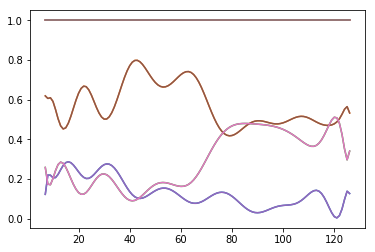

In [79]:
#fitted_params
res1 = fitted_params[5] / (fitted_params[5] + fitted_params[6] + fitted_params[7])
res2 = fitted_params[6] / (fitted_params[5] + fitted_params[6] + fitted_params[7])
res3 = fitted_params[7] / (fitted_params[5] + fitted_params[6] + fitted_params[7])
plt.plot(np.arange(7,127,1), fitted_params[5])
plt.plot(np.arange(7,127,1), fitted_params[6])
plt.plot(np.arange(7,127,1), fitted_params[7])
plt.plot(np.arange(7,127,1), (fitted_params[5] + fitted_params[6] + fitted_params[7]))
plt.plot(np.arange(7,127,1), res1)
plt.plot(np.arange(7,127,1), res2)
plt.plot(np.arange(7,127,1), res3)
plt.plot(np.arange(7,127,1), (res1 + res2 + res3))


In [80]:
np.savetxt(filedir + 'fitted_potparams_w_' + str(jj)+'_pols.txt', fitted_params)